In [45]:
import numpy as np
import timeit
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
def create_gbm_minute(init_price, mu, sigma, length):
    """
    Calculates an asset price path using the analytical solution
    to the Geometric Brownian Motion stochastic differential
    equation (SDE).

    Parameters
    ----------
    length : The int number needed to calculate length of the time series.
    init_price: Asset inital price.
    mu: The mean 'drift' of the asset.
    sigma: Volatility expressed annual terms.

    Returns
    -------
    `np.ndarray`
        The asset price path
    """
    n = length
    dt = 1 / (255 * 6.5 * 60) 

    asset_path = np.exp(
        (mu - sigma ** 2 / 2) * dt +
        sigma * np.random.normal(0, np.sqrt(dt), size=n)
    )

    return init_price * asset_path.cumprod()

In [4]:

def Function_runtime(func,*args, **kwargs):
    start = timeit.default_timer()
    result = func(*args, **kwargs)
    
    stop = timeit.default_timer()
    time = stop-start
    return result, time

In [5]:
minutes_length = int(255*6.5*60) 
num_assets = 10000
assets = np.zeros((num_assets,minutes_length))
for i in range(num_assets):
    if(i)%100 == 0:
        print(f"Generating asset path completed {int(i/num_assets*100)}%", end = "\r" )
    assets[i] = create_gbm_minute(100, 0.01, 0.2, minutes_length)
print(f"Generating asset path completed 100%", end = "\r" )

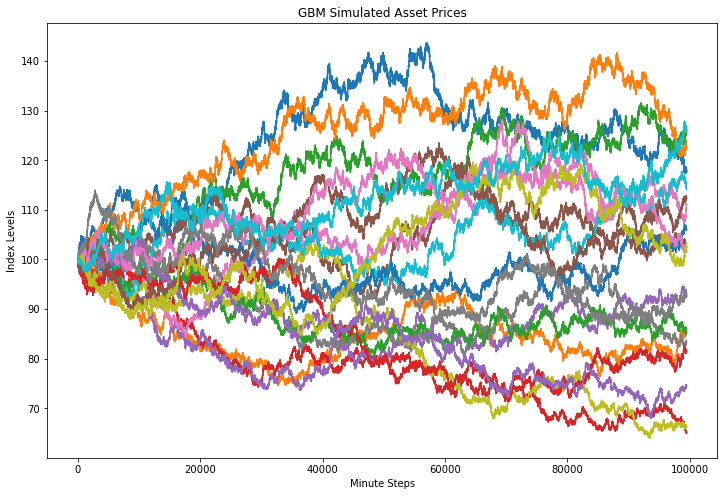

In [6]:
# Plot initial 10 simulated path using matplotlib
fig, axes = plt.subplots(1,1,figsize = (12,8))
for i in range(20):
    axes.plot(assets[i])
# plt.grid(True)
plt.xlabel('Minute Steps')
plt.ylabel('Index Levels')
plt.title('GBM Simulated Asset Prices');
fig.savefig("figures/prices_simulation.jpg",dpi=400)


In [7]:
asset_easy = assets[:100,:]
asset_medium = assets[:1000,:]
asset_hard = assets

In [18]:
easy_runtime = Function_runtime(np.cov, asset_easy)[1]
print(f"100 assets running time: {easy_runtime}")

100 assets running time: 0.04580404199998611


In [19]:
medium_runtime = Function_runtime(np.cov, asset_medium)[1]
print(f"1000 assets running time: {medium_runtime}")

1000 assets running time: 1.1430359170000202


In [67]:
hard_runtime = Function_runtime(np.cov, asset_hard)[1]
print(f"10000 assets running time: {hard_runtime}")

10000 assets running time: 149.4889714169999


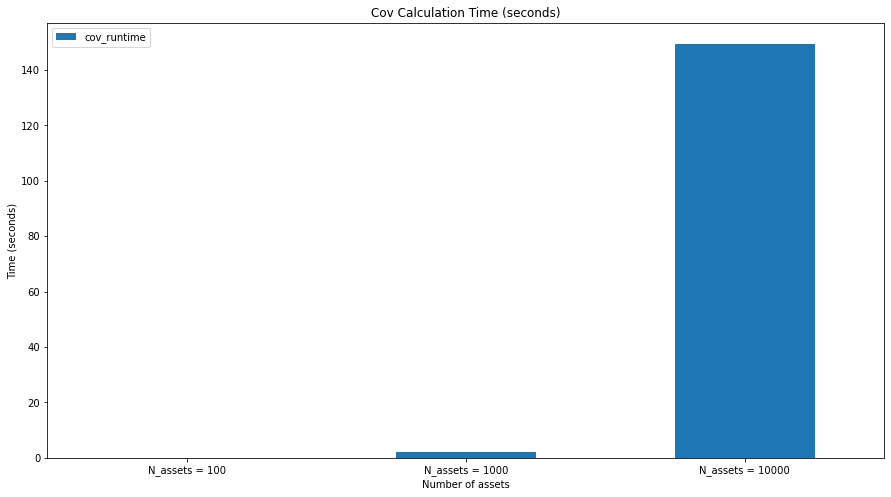

In [68]:
# plot the figures to demonstrate my conclusions
fig, axes = plt.subplots(1,1,figsize = (8,6))
label = ["N_assets = "+str(n) for n in [100,1000,10000]]

Runtime_pd = pd.DataFrame({
    "cov_runtime":[easy_runtime,medium_runtime,hard_runtime],
    },
    index=label)
Runtime_pd.plot.bar(rot = 0,figsize=(15, 8), ax = axes,title = "Cov Calculation Time (seconds)")
axes.set_xlabel('Number of assets')
axes.set_ylabel('Time (seconds)')
fig.savefig("figures/running_time.jpg",dpi=400)

In [69]:
np.around(Runtime_pd,2)

,cov_runtime
N_assets = 100,0.09
N_assets = 1000,2.06
N_assets = 10000,149.49


In [54]:
time_list = [10,100,200,500,800,1000,2000,3000,4000,5000, 10000]
cost_list = []
for t in time_list:
    cost = Function_runtime(np.cov, assets[:t,:])[1]
    print(f"run {t} in {cost}s")
    cost_list.append(cost)
cost_list

run 10 in 0.016841666999880545s
run 100 in 0.08385420800004795s
run 200 in 0.1651259579998623s
run 500 in 0.5310320000000956s
run 800 in 0.9833450000000994s
run 1000 in 1.2683445410000331s
run 2000 in 4.348831458999939s
run 3000 in 11.856809124999927s
run 4000 in 18.731427416000088s
run 5000 in 29.51702120899995s
run 10000 in 248.163807958s


[0.016841666999880545,
 0.08385420800004795,
 0.1651259579998623,
 0.5310320000000956,
 0.9833450000000994,
 1.2683445410000331,
 4.348831458999939,
 11.856809124999927,
 18.731427416000088,
 29.51702120899995,
 248.163807958]

In [23]:
cost_list

[0.013979917000028763,
 0.08188883299999361,
 0.12954850000005536,
 0.48302141700003176,
 0.942605833000016,
 1.2257840830000077,
 4.047785584000053,
 8.116935084000033,
 15.320124291999946,
 24.31059008300008]

In [48]:
def func(x, a, b, c):
    return a * x**2 + b*x + c

In [49]:
popt, pcov = curve_fit(func, time_list, cost_list)
popt, pcov

(array([ 9.95936523e-07, -1.92774904e-04,  2.16146619e-01]),
 array([[ 1.57118971e-15, -7.35579132e-12,  3.42871796e-09],
        [-7.35579132e-12,  3.69395028e-08, -2.02081413e-05],
        [ 3.42871796e-09, -2.02081413e-05,  2.14791641e-02]]))

array([     0.,    100.,    200., ...,  99800.,  99900., 100000.])

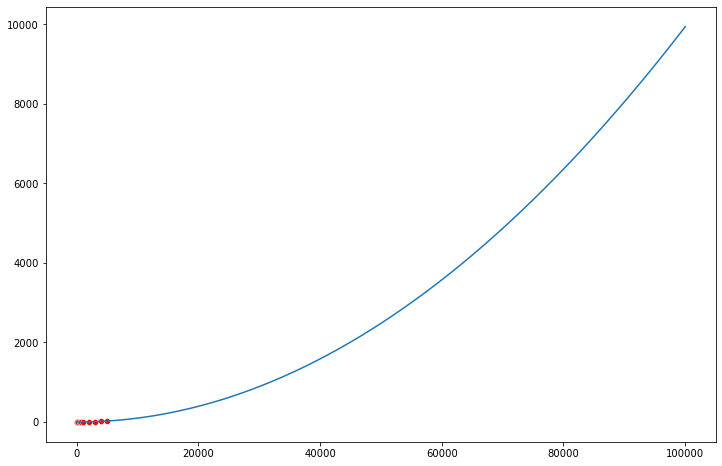

In [53]:
# Plot initial 10 simulated path using matplotlib
fig, ax = plt.subplots(1,1,figsize = (12,8))
sns.scatterplot(time_list, cost_list,ax = ax, color = 'r')
xdata = np.linspace(0, 100000, 1001)
y = func(xdata, popt[0], popt[1], popt[2])
ax.plot(xdata, y)